# Cleaning the Used Vehicles dataset
## Daniel Mortenson

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [ ]:
df0 = pd.read_csv("vehicles.csv",index_col = 0)
print(df0.shape)

(458213, 25)


### First, we can drop all samples (rows) that have missing values (NaNs)

In [ ]:
df1 = df0.dropna()
print(df1.shape)

(42384, 25)


### This leaves only 42,384/458,213 = 9.2% of our data, so we need to try something more intelligent.

### Instead we can fill in missing numerical values with the averages of each numerical column:

In [ ]:
print( df0.describe())

                 id         price           year      odometer            lat  \
count  4.582130e+05  4.582130e+05  457163.000000  4.029100e+05  450765.000000   
mean   7.235233e+09  4.042093e+04    2010.746067  1.016698e+05      38.531925   
std    4.594362e+06  8.194599e+06       8.868136  3.228623e+06       5.857378   
min    7.208550e+09  0.000000e+00    1900.000000  0.000000e+00     -82.607549   
25%    7.231953e+09  4.900000e+03    2008.000000  4.087700e+04      34.600000   
50%    7.236409e+09  1.099500e+04    2013.000000  8.764100e+04      39.244500   
75%    7.239321e+09  2.149500e+04    2016.000000  1.340000e+05      42.484503   
max    7.241019e+09  3.615215e+09    2021.000000  2.043756e+09      82.049255   

                long  
count  450765.000000  
mean      -94.375824  
std        18.076225  
min      -164.091797  
25%      -110.890427  
50%       -88.314889  
75%       -81.015022  
max       150.898969  


In [ ]:
df2 = df0.copy()
#our numerical columns:
num_cols = ['id','price', 'year', 'odometer', 'lat', 'long']
for c in num_cols:
    mean = df2[c].mean()
    df2[c] = df2[c].fillna(mean)

### But, there are still NaNs in the categorical columns as well, we'll replace those with string 'none'

In [ ]:
#since there should be no more nans in the numerical columns, 
#we can fill the entire dataframe with nans without worrying
df2.fillna('none', inplace = True)

### Now, we can drop NaNs and see that we kept every single sample

In [ ]:
df2 = df2.dropna()
print(df2.shape)

(458213, 25)


### Let's see what our base accuracy is using SKLearn DecisionTreeRegressor

In [ ]:
df3 = df2.copy()
df3 = shuffle(df3)
#get rid of pesky price outliers
df3.loc[df3['price'] > 60000, 'price'] = np.nan
#drop cars listed for free
df3.loc[df3['price'] < 50, 'price'] = np.nan
df3.dropna(inplace= True,axis = 0)

y = df3['price']
print(df3.columns)
X = df3.drop(["price"],axis =1)
#for use with SKLearn, we will one-hot encode text 
#features for columns that have <= 10 unique values, drop the others
for col in X.columns:
    if col not in num_cols:
        if len(pd.unique(X[col])) < 10:
            new_cols = pd.get_dummies(X[col],prefix = col)
            X = pd.concat([X,new_cols],axis =1)
            print(f"Added {new_cols.shape[1]} columns to dataframe for {col}")
            X = X.drop([col],axis= 1)
        else:
            X = X.drop([col],axis = 1)
            print(f"Dropped {col} for having too many values")
print(f"After Cleaning: our data is {X.shape}")

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'state', 'lat', 'long', 'posting_date'],
      dtype='object')
Dropped url for having too many values
Dropped region for having too many values
Dropped region_url for having too many values
Dropped manufacturer for having too many values
Dropped model for having too many values
Added 7 columns to dataframe for condition
Added 9 columns to dataframe for cylinders
Added 6 columns to dataframe for fuel
Added 7 columns to dataframe for title_status
Added 4 columns to dataframe for transmission
Dropped VIN for having too many values
Added 4 columns to dataframe for drive
Added 5 columns to dataframe for size
Dropped type for having too many values
Dropped paint_color for having too many values
Dropped image_url for having too many valu

Median Absolute Error: 700.0


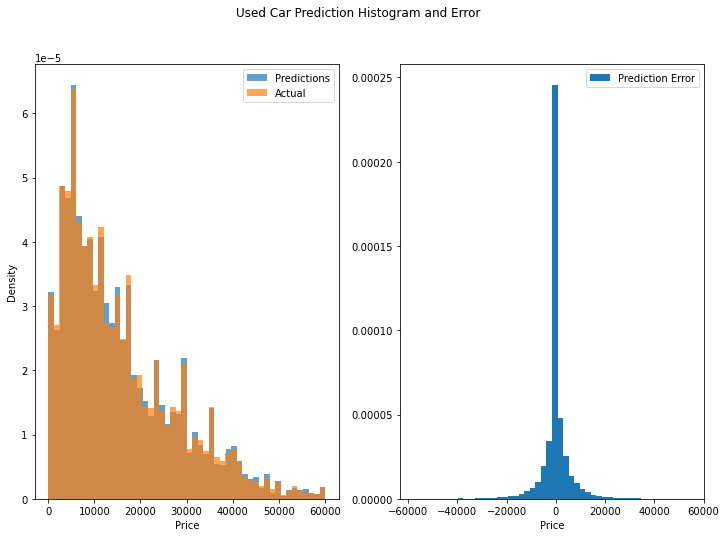

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
regressor = DecisionTreeRegressor(random_state=0).fit(X.to_numpy()[:400000],y.to_numpy()[:400000])
pred = regressor.predict(X.to_numpy()[400000:])
error = pred - y.to_numpy()[400000:]
print(f"Median Absolute Error: {np.median(np.abs(error))}")
fig,ax = plt.subplots(1,2)
ax[0].hist(pred.T,label = "Predictions",alpha = .7,bins = 50, density = True)
ax[0].hist(y, label = "Actual",alpha = .7,bins = 50,density = True)
ax[0].set_xlabel("Price")
ax[0].set_ylabel("Density")
ax[0].legend()
ax[1].hist(error,label = "Prediction Error",bins = 50,density = True)
ax[1].set_xlabel("Price")
ax[1].legend()
plt.suptitle("Used Car Prediction Histogram and Error");